# Лабораторная работа 1

Выполнил студент группы J4240: Кондратов Павел Анатольевич


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# для проверки стационарности
from statsmodels.tsa.stattools import adfuller


import optuna
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

Используемые данные: Индекс промышленного производства c января 2009 года по август 2024 года

In [2]:
data = pd.read_excel("IPI_m.xlsx", sheet_name="IPI")
data = data[data["date"] >= "2009-01-01"]
data = data.sort_values("date")
data = data.set_index("date")
data.tail()

,ipi_m
date,
2024-04-01,111.9300
2024-05-01,113.1026
2024-06-01,111.0772
2024-07-01,113.4224
2024-08-01,115.3412


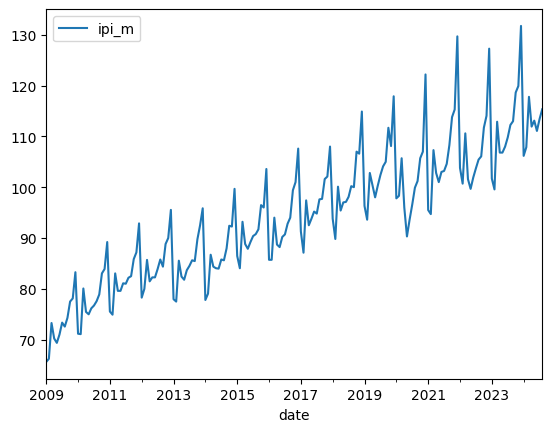

In [3]:
data.plot()
plt.show()

Видим в явном виде сезонность и тренд. Отлично подойдет для нашей модели. Вдобавок нет стационарности. Выполнены предпосылки модели Хольта-Уинтерса

In [4]:
# Проведем тест на стационарность


# Из официальной документации
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC", regression="ct")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)


adf_test(data)

Results of Dickey-Fuller Test:
Test Statistic                  -3.726921
p-value                          0.020645
#Lags Used                      12.000000
Number of Observations Used    175.000000
Critical Value (1%)             -4.011455
Critical Value (5%)             -3.435882
Critical Value (10%)            -3.141957
dtype: float64


Так как p-value > 1%, то мы не отвергаем нулевую гипотезу. Значит есть единичный корень. Это значит, что ряд не является стационарным

In [5]:
class HoltWiinters:

    def __init__(self, L, alpha, beta, gamma, m=0):
        """
        Модель Хольта-Винтерса

        Input:

            L - количество периодов в сезоне

            alpha - параметр сглаживания опорной компоненты

            beta - параметр сглаживания сезонной компоненты

            gamma - параметр сглаживания тренда

            m - количество периодов для предсказания во время обучения

        Output:

            None

        """

        # входные параметры
        self.m = m
        self.L = L
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        # Эндогенные параметры
        self.t = 0
        self.S = []
        self.b = []
        self.I = []
        self.F = []

    @staticmethod
    def objective(trial, L=12, m=2):
        alpha = trial.suggest_float("alpha", 0, 1.0)
        beta = trial.suggest_float("beta", 0, 1.0)
        gamma = trial.suggest_float("gamma", 0, 1.0)

        # Fit Holt-Winters model with (alpha, beta, gamma)
        # Compute error (e.g., MSE)
        model = HoltWiinters(L, alpha, beta, gamma, m)
        model.fit(data)
        error = model.count_MSE()
        return error

    def fit_optuna(self, data, n_trials=100):
        """
        Метод для автоматического подбора гиперпараметров модели с использованием Optuna

        Input:

            data - данные для обучения

            n_trials - количество итераций обучения

        Output:

            None
        """
        optuna.logging.set_verbosity(optuna.logging.WARNING)

        study = optuna.create_study(direction="minimize")
        study.optimize(self.objective, n_trials=n_trials)

        self.alpha = study.best_params["alpha"]
        self.beta = study.best_params["beta"]
        self.gamma = study.best_params["gamma"]
        self.fit(data)

    def fit(self, data):
        """
        Метод для обучения модели

        Input:

            data - данные для обучения


        Output:

            None
        """
        # Приводим данные к удобному формату
        self.y = data["ipi_m"].to_numpy().squeeze()
        self.data = data

        # Инициализируем компоненты
        self.initial_components()

        # Обучение (получение предсказаний на тренировочных данных)
        for i in range(len(self.y)):
            self.t = i

            self._overall_smoothing()
            self._trend_smoothing()
            self._seasonal_smoothing()
            self._predict()

    def forecast(self, m=None):
        """
        Метод для предсказания значений на m периодов

        Input:

            m - количество периодов для предсказания

        Output:

            Предсказание для периода t+m
        """

        if m is not None:
            self.m = m

        return (self.S[self.t] + self.m * self.b[self.t]) * self.I[
            self.t - self.L + self.m
        ]

    def _predict(self, m=None):
        """
        Метод для предсказания значений на m периодов. Нужен для обучения

        Input:

            m - количество периодов для предсказания

        Output:

            Предсказание для периода t+m
        """

        self.F.append(
            (self.S[self.t] + self.m * self.b[self.t])
            * self.I[self.t - self.L + self.m]
        )

    def _overall_smoothing(self):
        """
        Метод для посчета опорной компоненты на шаге t
        """
        self.S.append(
            self.alpha * self.y[self.t - 1] / self.I[self.t - self.L]
            + (1 + self.alpha) * (self.S[self.t - 1] + self.b[self.t - 1])
        )

    def _trend_smoothing(self):
        """
        Метод для посчета тренда на шаге t
        """
        self.b.append(
            self.gamma * (self.S[self.t] - self.S[self.t - 1])
            + (1 - self.gamma) * self.b[self.t - 1]
        )
        pass

    def _seasonal_smoothing(self):
        """
        Метод для посчета сезонной компоненты на шаге t
        """
        self.I.append(
            self.beta * self.y[self.t] / self.S[self.t]
            + (1 - self.beta) * self.I[self.t - self.L]
        )
        pass

    def plot(self):
        """
        Метод для визуализации пердсказаний во время обучения и исходного ряда
        """
        preds = []
        for i in range(self.L):
            preds.append(self.forecast(i))
        plt.plot(self.F + preds, label="predicted")
        plt.plot(self.y, label="source")
        plt.title(
            f"MSE: {round(self.count_MSE(),3)}, alpha: {round(self.alpha, 3)}, beta: {round(self.beta, 3)}, gamma: {round(self.gamma, 3)}"
        )
        plt.axvline(len(self.y), linestyle="--", label="Last observation")
        plt.legend()
        plt.show()

    def count_MSE(self):
        """
        Метод для подсчета MSE. Нужен для оценивания качества модели
        """
        return root_mean_squared_error(self.y, self.F)

    def initial_components(self):
        """
        Метод для инициализации компонент
        """
        # Берем среднее за первый период сезонности
        self.S.append(np.mean(self.y[: self.L]))
        # Отношение среднего во втором сезонном периоде к среднему первого сезонного периода
        self.b.append(
            np.mean(self.y[self.L : 2 * self.L]) / np.mean(self.y[: self.L]) - 1
        )
        # Считаем долю каждого из наблюдений первого периода сезонности по отношению к среднему
        for i in range(self.L):
            self.I.append(self.y[i] / self.S[0])

Пример работы простого обучения

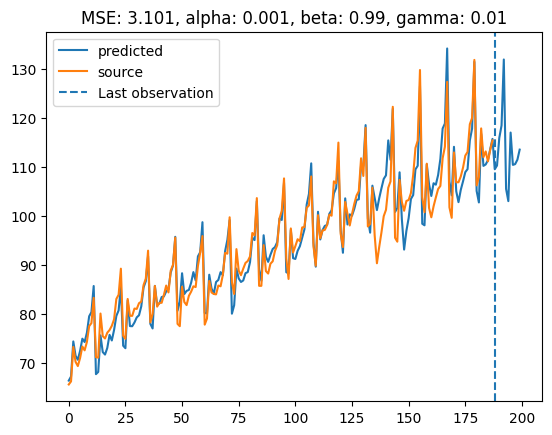

In [6]:
model = HoltWiinters(12, 0.001, 0.99, 0.01, 12)
model.fit(data)
model.plot()

Пример работы с тюнингом параметров

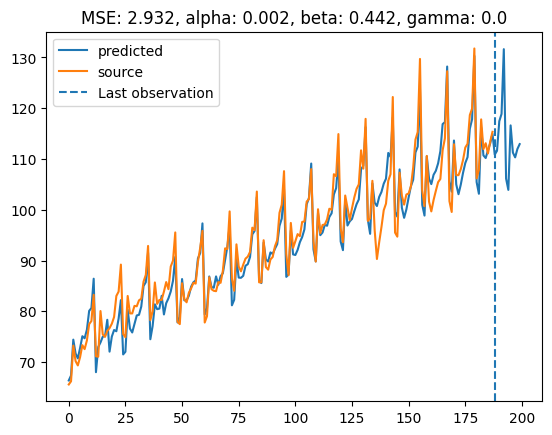

In [9]:
model = HoltWiinters(12, 0.001, 0.99, 0.01, 12)
model.fit_optuna(data, n_trials=2000)
model.plot()